**Example of Coordinate Based HP-Lattice model**

by: Hanna Linn

In [1]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
import math
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from vqa.hamiltonian.protein_folding import protein_folding_hamiltonian
from vqa.hamiltonian.Protein_models.CoordinateBased_HPLattice import CoordinateBased_HPLattice
from vqa.utils.protein_utils import *
from collections import Counter


In [2]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 2
L2 = 2

lambda_vector = (2.1, 2.4, 3)

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  0.   0.   2.4  0.  -1.  -1. ]
 [ 4.2  0.   0.   0.   0.   2.4 -1.  -1. ]
 [ 0.   0.   0.   4.2  0.   0.   2.4  0. ]
 [ 0.   0.   4.2  0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   4.2  0.   0. ]
 [ 0.   2.4  0.   0.   4.2  0.   0.   0. ]
 [-1.  -1.   2.4  0.   0.   0.   0.   4.2]
 [-1.  -1.   0.   2.4  0.   0.   4.2  0. ]]
Dn:
[2, 2, 2, 2]


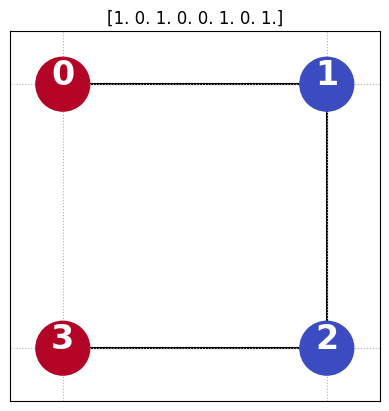

In [3]:
# Draw the protein
protein.viz_lattice(feasible_set[0])

[1. 0. 1. 0. 0. 1. 0. 1.]
[1. 0. 0. 1. 0. 1. 1. 0.]
[0. 1. 1. 0. 1. 0. 0. 1.]
[0. 1. 0. 1. 1. 0. 1. 0.]


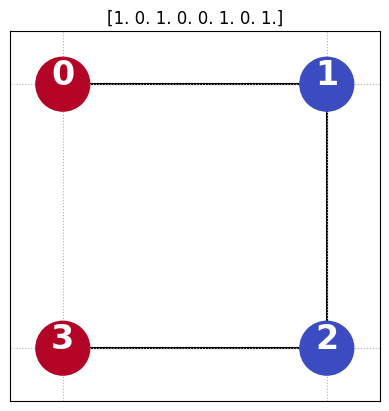

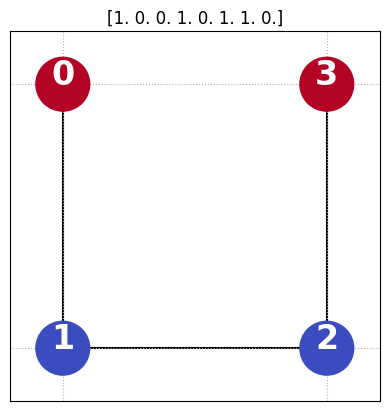

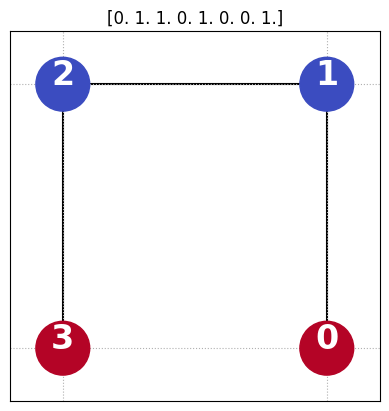

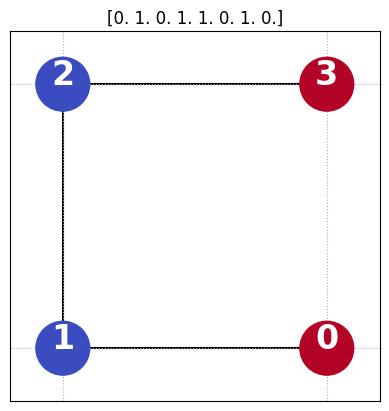

In [4]:
# Draw all proteins in feasible solution set
for j,i in enumerate(feasible_set):
    plt.figure(j)
    protein.viz_lattice(i)
    print(i)

In [6]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits)

H_mixer = qaoa.x_mixer(qubits)

print('H_cost:\n' + str(H_cost))
print()
print('H_mixer:\n' + str(H_mixer))

H_cost:
  (-0.6) [Z4]
+ (-0.6) [Z5]
+ (-0.6) [Z2]
+ (-0.6) [Z3]
+ (-0.09999999999999998) [Z6]
+ (-0.09999999999999998) [Z7]
+ (-0.09999999999999998) [Z0]
+ (-0.09999999999999998) [Z1]
+ (-0.25) [Z0 Z6]
+ (-0.25) [Z0 Z7]
+ (-0.25) [Z1 Z6]
+ (-0.25) [Z1 Z7]
+ (0.0) [Z0 Z2]
+ (0.0) [Z0 Z3]
+ (0.0) [Z0 Z5]
+ (0.0) [Z1 Z2]
+ (0.0) [Z1 Z3]
+ (0.0) [Z1 Z4]
+ (0.0) [Z2 Z4]
+ (0.0) [Z2 Z5]
+ (0.0) [Z2 Z7]
+ (0.0) [Z3 Z4]
+ (0.0) [Z3 Z5]
+ (0.0) [Z3 Z6]
+ (0.0) [Z4 Z6]
+ (0.0) [Z4 Z7]
+ (0.0) [Z5 Z6]
+ (0.0) [Z5 Z7]
+ (0.6) [Z0 Z4]
+ (0.6) [Z1 Z5]
+ (0.6) [Z2 Z6]
+ (0.6) [Z3 Z7]
+ (1.05) [Z0 Z1]
+ (1.05) [Z2 Z3]
+ (1.05) [Z4 Z5]
+ (1.05) [Z6 Z7]

H_mixer:
  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]
+ (1) [X6]
+ (1) [X7]



0: ──H─╭RZZ(0.00)─╭RZZ(0.00)─╭RZZ(0.00)─╭RZZ(0.00)──RZ(-0.00)─╭RZZ(0.00)─╭RZZ(-0.00)─╭RZZ(-0.00)
1: ──H─╰RZZ(0.00)─│──────────│──────────│─────────────────────│──────────│───────────│──────────
2: ──H────────────╰RZZ(0.00)─│──────────│─────────────────────│──────────│───────────│──────────
3: ──H───────────────────────╰RZZ(0.00)─│─────────────────────│──────────│───────────│──────────
4: ──H──RZ(-0.00)───────────────────────╰RZZ(0.00)────────────│──────────│───────────│──────────
5: ──H──RZ(-0.00)─────────────────────────────────────────────╰RZZ(0.00)─│───────────│──────────
6: ──H──RZ(-0.00)────────────────────────────────────────────────────────╰RZZ(-0.00)─│──────────
7: ──H──RZ(-0.00)────────────────────────────────────────────────────────────────────╰RZZ(-0.00)

───RX(0.00)────────────────────────────────────────────────────────────────────────────────
──╭RZZ(0.00)─╭RZZ(0.00)─╭RZZ(0.00)──RZ(-0.00)─╭RZZ(0.00)─╭RZZ(-0.00)─╭RZZ(-0.00)──RX(0.00)─
──╰RZZ(0.00)─│──────────│─────────────

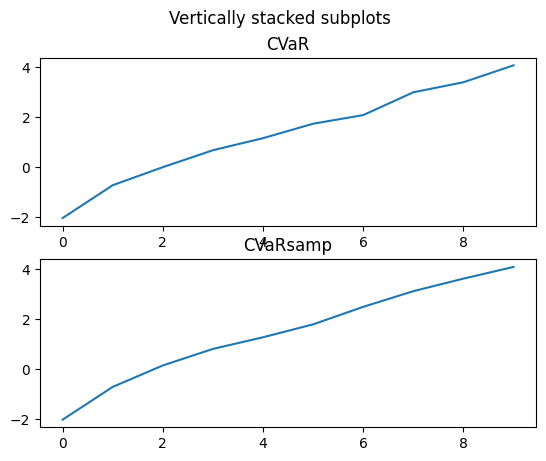

In [7]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params):     # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1])
    

# If we add a expectation value we get a cost function for average cost of the cost Hamiltonian for given parameters
@qml.qnode(dev)
def average_cost(params):
    circuit(params)
    return qml.expval(H_cost)

# Obtains the probability for all the states
@qml.qnode(dev)
def get_probs(params):
    circuit(params)
    return qml.probs(wires = qubits)

# CVaR function for known energies and probabilities
def CVaR(params,alpha=0.25):
    circuit(params)
    
    Energy_list = get_energies_index_states(H_cost)
    Energy_array = np.column_stack((Energy_list, get_probs(params)))
    Energy_array = Energy_array[Energy_array[:, 0].argsort()]
    
    
    Probability_array = np.array(Energy_array[0:len(Energy_list),1])
    Probability_vector = Probability_array[Probability_array.cumsum() <= alpha]
    
    K = len(Probability_vector)
    Energy_vector = Energy_array[0:K,0]
    exp_CVaR = np.dot(Energy_vector, Probability_vector)/np.sum(Probability_vector)
   
    return exp_CVaR

def CVaRsamp(params, alpha=0.25,n=1000):#n=antal samples 
    
    # Denna o CVaR ger inte samma, har haft svårt att bestämma varför. Om man normaliserar väntevärdet i CVaR som kommentaren innan
    # return i CVaRfunktionen så blir graferna ganska lika form, men värdena är fortfarande shit, och optimeringen blir kass. Känns som att det har o 
    #göra med att urvalet av energier/samples inte är helt ekvivalent mellan dem, alltså CVaR väljer de a% konfigurationerna med minst energi,oberoende av sannolikhet, 
    #medan CVaRsamp väljer de a% samplesen med minst. 
    
    #Svårt att formulera men alltså om vi säger att alpha =0.1, så
    #kommer CVaR ta de 256*0.1=26 minsta energierna och summera dem, trots att deras ihoplagda sannolikhet bara är 1.3% (summera Probability_vector)
    #CVaRsamp kommer däremot ta de 100 minsta samplesen, som (om vi antar att slumpen tar ut sig) därför har en ihoplagd sannolikhet
    #på 10%. Så tycker det verkar som att alpha inte funkar på samma sätt i funktionerna. vet dock itte vilket sätt som e bäst eller rätt. 
    #men för att ändra på CVaR om man nu skulle vilja hade man nog bara kunnat summera varje item i probs tills summan överstiger alpha, ex i en whileloop. 

    circuit(params)
    
    probs = get_probs(params)  # hämta sannolikhetsfördelningen (matris, första värdet är p(00000000), andra är p(00000001) osv)
    
    index_samples= np.random.choice(np.arange(len(probs), dtype=int), size=n, replace=True,p=probs)  # tar n samples av probs, ger skum lista med index motsvarande konfiguration (index 0 är tillståndet 00000000, index 1 =00000001 osv)
    energy_of_samples=energies_of_set(protein.get_solution_set(), H_cost,8) [index_samples]  #ger en lista där index i index_samples är utbytta mot deras motsvarande energi. 
    sorted_energy_samples=sort_over_threshhold(energy_of_samples,-10)[0] #sorterar hela energilistan
    K=int(alpha*n) #antal samples att ta väntevärde över. 
    summa=sum(sorted_energy_samples[:K]) #summera de K minsta energierna.
    expvalue=summa/K 
    return expvalue
    

def CVaRcompare(): #jämför resultaten av CVaR och CVaRsamp vid olika alpha genom att plotta väntevärdena.
    testCVaR=[]
    testCVaRsamp=[]
    for a in range(10):
        testCVaR.append(CVaR(half_parameters,(a+1)/10))
        testCVaRsamp.append(CVaRsamp(half_parameters,(a+1)/10,100000))
    fig, axs = plt.subplots(2)
    fig.suptitle('Vertically stacked subplots')
    axs[0].plot(testCVaR)
    axs[0].title.set_text('CVaR')
    axs[1].plot(testCVaRsamp) 
    axs[1].title.set_text('CVaRsamp')
    


# Let's test it!
zero_parameters = np.array([[0],[0]])
half_parameters = np.array([[0.5],[0.5]])
test_parameters = np.array([[0.1],[0.1]])
p = 1

CVaRcompare()

#print('CVaRsamp cost with gamma=0.5 and beta=0.5 and alpha=0.25:\n', CVaRsamp(half_parameters, 0.25,10000)) #(param, alpha, n)
#print('CVaRsamp cost with gamma=0.0 and beta=0.0 and alpha=1:\n', CVaRsamp(zero_parameters, 1,10000)) #(param, alpha, n)


#print('Average cost with gamma=0 and beta=0:\n', average_cost(zero_parameters))
#print('CVaR cost with gamma=0 and beta=0 and alpha=0.25:\n', CVaR(zero_parameters))
#print('Average cost with gamma=0.5 and beta=0.5:\n', average_cost(half_parameters))
#print('CVaR cost with gamma=0.5 and beta=0.5 and alpha=0.25:\n', CVaR(half_parameters,1))
#print('Average cost with gamma=0.1 and beta=0.1:\n', average_cost(test_parameters))
#print('CVaR cost with gamma=0.1 and beta=0.1 and alpha=0.25:\n', CVaR(test_parameters))
# Draw our circuit
print()
print(qml.draw(average_cost, expansion_strategy = 'device')(zero_parameters))

In [8]:
# Optimisation of the circuit

optimiser = qml.GradientDescentOptimizer()
steps = 100
initial_params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad = True)
p = 2

cost_vector = np.zeros(steps)
cost_vector[0] = average_cost(initial_params) #expval
#cost_vector[0] = CVaR(initial_params) #cvar
params_vector = np.zeros((steps, 2, p))

params = initial_params
for i in range(steps):
    params_vector[i] = params
    params, cost_ = optimiser.step_and_cost(average_cost, params) #expval
    #params, cost_ = optimiser.step_and_cost(CVaR, params) #cvar
    cost_vector[i] = cost_

best_params_optimisation = params
print('Optimal parameters:\n', best_params_optimisation)
print('Average cost for the best parameters:\n', average_cost(best_params_optimisation))

Optimal parameters:
 [[0.57095121 1.00177752]
 [0.46758901 0.8606756 ]]
Average cost for the best parameters:
 -2.158427053893477


/tmp/ipykernel_5068/1030856177.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Text(0.5, 1.0, 'Optimisation of $\\gamma$ and $\\beta$')

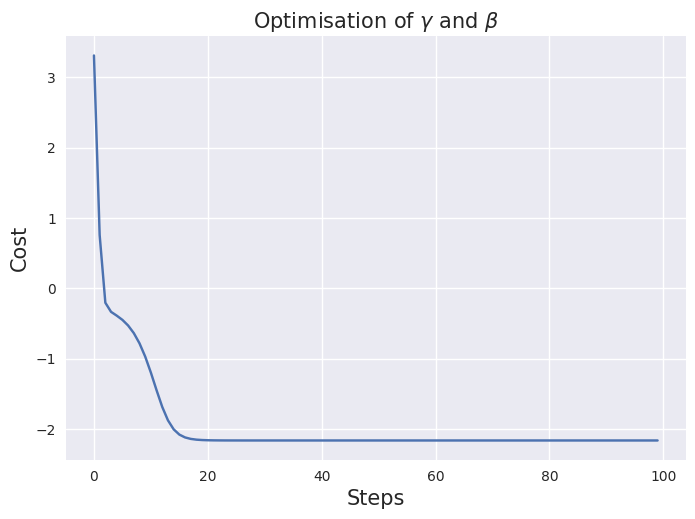

In [9]:
plt.style.use("seaborn")
plt.plot(cost_vector)
plt.xlabel('Steps', fontsize = 15)
plt.ylabel('Cost', fontsize = 15)
plt.title(r'Optimisation of $\gamma$ and $\beta$', fontsize = 15)

In [10]:
# Probability of measuring the different answers
@qml.qnode(dev)
def probability_circuit(params):
    circuit(params)
    return qml.probs(wires=qubits)

probs = probability_circuit(best_params_optimisation)


Success probability of training:  0.1540422241133192


<Figure size 800x550 with 0 Axes>

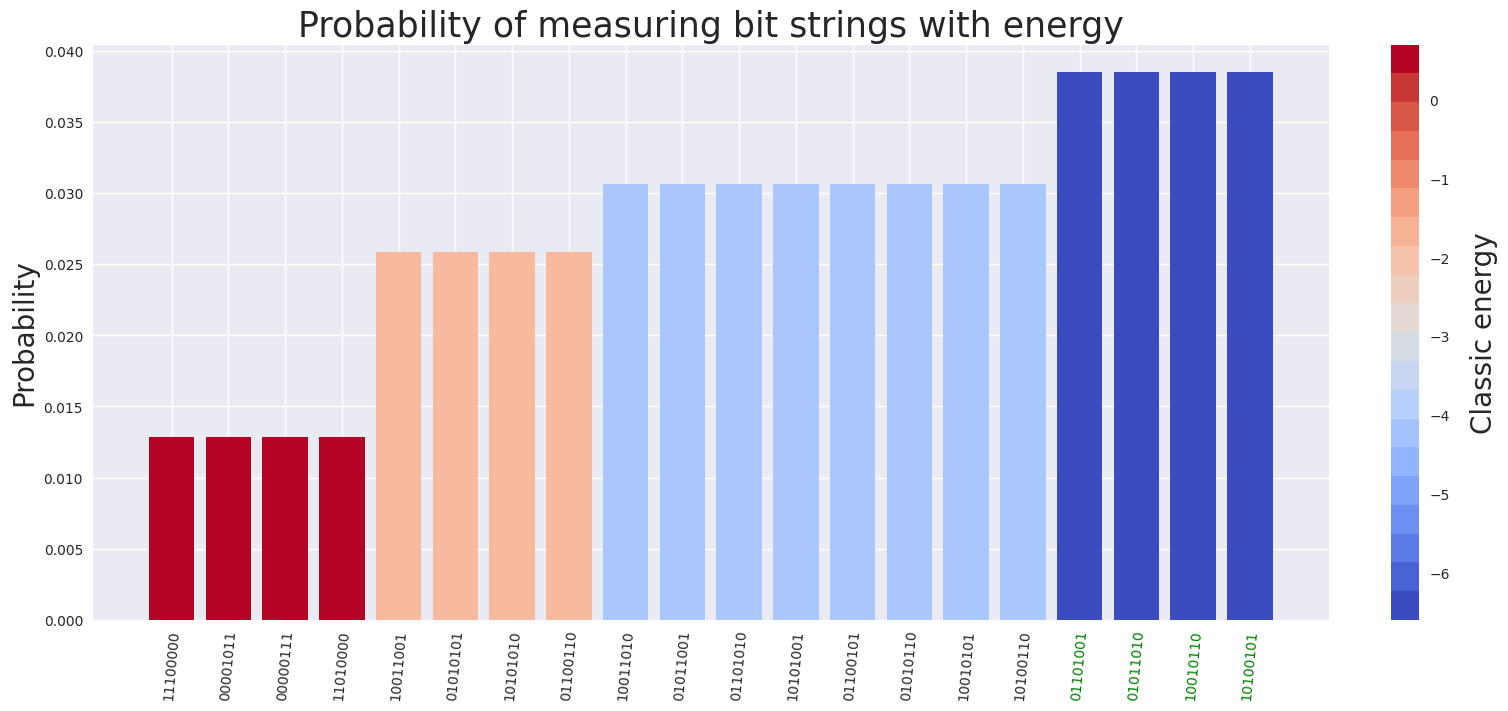

In [11]:
# Fancy plot, the one above is unclar if we succeeded
ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states

print('Success probability of training: ', np.sum(probs[ground_states_i]))
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i) # plot probability over bitstrings

/home/petdit42/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)


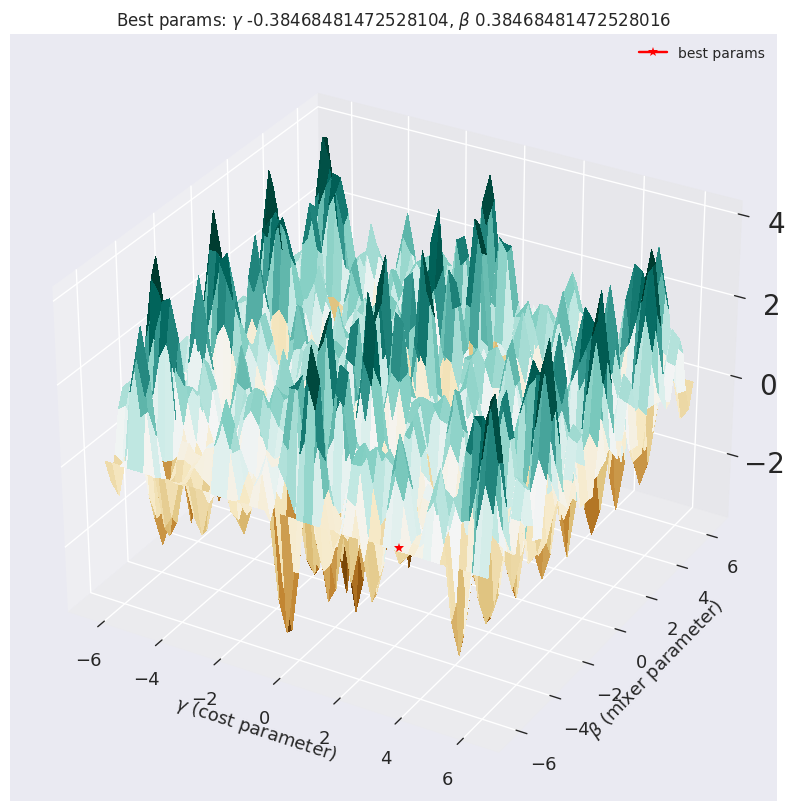

In [55]:
# Grid search
p = 1 # grid search with p > 2 is messy

start_gamma = -2*np.pi
stop_gamma = 2*np.pi
num_points_gamma = 50

start_beta = -2*np.pi
stop_beta = 2*np.pi
num_points_beta = 50

# Gamma
X = np.linspace(start_gamma, stop_gamma, num_points_gamma)
# Beta
Y = np.linspace(start_beta, stop_beta, num_points_beta)

grid_search_params, Z, i = grid_search(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta,
					average_cost,
					above = False,
					save = False)

In [ ]:
# More plotting, from above

X, Y, _= get_batch_array(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta)
                
plot_grid_search(X,
					Y,
					Z,
					i,
					above = True,
					name = '',
					save = False)

In [ ]:
# Is the grid search better?
probs = probability_circuit(grid_search_params)

plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i)

print('Success probability of grid search: ', np.sum(probs[ground_states_i]))

In [ ]:
# Or we can do annealing parameters
annealing_params = get_annealing_params(annealing_time=2, p=15, linear = True, cosine = False)
probs = probability_circuit(annealing_params)

print('Success probability of annealing parameters: ', np.sum(probs[ground_states_i]))
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i) # plot probability over bitstrings